<a href="https://colab.research.google.com/github/MrSuperfluous/SummerAnal/blob/main/summeranal_hacky_self.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter, find_peaks
from scipy.fft import fft
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif

# Configuration
RANDOM_STATE = 42
PCA_COMPONENTS = 3

# NDVI columns extracted from your screenshot
NDVI_COLS = [
    '20150720_N', '20150602_N', '20150517_N', '20150501_N', '20150415_N', '20150330_N',
    '20150314_N', '20150226_N', '20150210_N', '20150125_N', '20150109_N', '20141117_N',
    '20141101_N', '20141016_N', '20140930_N', '20140813_N', '20140626_N', '20140610_N',
    '20140525_N', '20140509_N', '20140423_N', '20140407_N', '20140322_N', '20140218_N',
    '20140202_N', '20140117_N', '20140101_N'
]


In [ ]:
def process_time_series(ts):
    ts = pd.Series(ts)

    # Convert invalid or missing values to NaN
    ts.replace([-np.inf, np.inf], np.nan, inplace=True)

    # Fill missing values with interpolation (time-insensitive)
    ts.interpolate(method='linear', limit_direction='both', inplace=True)

    # If still NaN, fill with median
    ts.fillna(ts.median(), inplace=True)

    # Smoothing: only if we have enough points
    if len(ts) >= 5:
        window_size = min(7, len(ts) // 2)
        if window_size % 2 == 0: window_size -= 1
        if window_size > 2:
            try:
                ts = savgol_filter(ts, window_length=window_size, polyorder=2)
            except Exception:
                ts = ts.values  # fallback

    return ts

def extract_features(ts):
    features = [
        np.mean(ts), np.median(ts), np.std(ts), np.ptp(ts),
        np.percentile(ts, 25), np.percentile(ts, 75),
        np.percentile(ts, 75) - np.percentile(ts, 25)  # IQR
    ]

    try:
        peaks, _ = find_peaks(ts, distance=3)
        features.extend([
            len(peaks),
            np.mean(np.diff(peaks)) if len(peaks) > 1 else 0,
            np.mean(ts[peaks]) if len(peaks) > 0 else 0
        ])
    except:
        features.extend([0, 0, 0])

    try:
        fft_vals = np.abs(fft(ts))
        features.extend([
            np.argmax(fft_vals[1:len(fft_vals)//2]) + 1,
            np.max(fft_vals),
            np.sum(fft_vals[:5])
        ])
    except:
        features.extend([0, 0, 0])

    return features


In [ ]:
train_df = pd.read_csv('train.csv')
train_features = []
train_series = []

for _, row in train_df.iterrows():
    raw_ts = row[NDVI_COLS].values.astype(float)
    ts = process_time_series(raw_ts)
    train_series.append(ts)
    train_features.append(extract_features(ts))

pca = PCA(n_components=PCA_COMPONENTS)
train_pca = pca.fit_transform(train_series)

X = np.hstack([train_features, train_pca])
y = train_df['class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [ ]:
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X, y_encoded)

class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(zip(np.unique(y_encoded), class_weights))

X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [ ]:
best_model = None
best_score = 0

for C in [0.01, 0.05, 0.1, 0.5, 1.0]:
    model = LogisticRegression(
        multi_class='multinomial',
        solver='saga',
        max_iter=2000,
        class_weight=class_weights,
        penalty='l2',
        C=C,
        random_state=RANDOM_STATE
    )
    model.fit(X_train_scaled, y_train)
    val_pred = model.predict(X_val_scaled)

    report = classification_report(y_val, val_pred, output_dict=True)
    weighted_f1 = report['weighted avg']['f1-score']

    if weighted_f1 > best_score:
        best_score = weighted_f1
        best_model = model
print("Optimized Validation Report:")
print(classification_report(y_val, best_model.predict(X_val_scaled), target_names=le.classes_))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: 

Optimized Validation Report:
              precision    recall  f1-score   support

        farm       0.31      0.45      0.37       168
      forest       0.94      0.54      0.69      1232
       grass       0.09      0.49      0.15        39
  impervious       0.72      0.77      0.74       134
     orchard       0.01      0.33      0.02         6
       water       0.18      0.57      0.28        21

    accuracy                           0.55      1600
   macro avg       0.38      0.53      0.37      1600
weighted avg       0.82      0.55      0.64      1600



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# Retrain on full data
full_model = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    max_iter=2000,
    class_weight=class_weights,
    penalty='l2',
    C=best_model.C,
    random_state=RANDOM_STATE
)
full_model.fit(scaler.fit_transform(X_selected), y_encoded)

# Process test data
test_df = pd.read_csv('test.csv')
test_features = []
test_series = []

for _, row in test_df.iterrows():
    ts = process_time_series(row[NDVI_COLS].values.astype(float))
    test_features.append(extract_features(ts))
    test_series.append(ts)

test_pca = pca.transform(test_series)
X_test = np.hstack([test_features, test_pca])
X_test_selected = selector.transform(X_test)
X_test_scaled = scaler.transform(X_test_selected)

# Predict
test_preds = full_model.predict(X_test_scaled)
test_df['class'] = le.inverse_transform(test_preds)

# Save submission
submission = test_df[['ID', 'class']]
submission.to_csv('submission.csv', index=False)
print("✅ Submission saved successfully as submission.csv!")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Submission saved successfully as submission.csv!


In [ ]:
# Re-import necessary libraries after code execution state reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load train CSV
train_df = pd.read_csv("train.csv")

# NDVI columns based on earlier user input
NDVI_COLS = [
    '20150720_N', '20150602_N', '20150517_N', '20150501_N', '20150415_N',
    '20150330_N', '20150314_N', '20150226_N', '20150210_N', '20150125_N',
    '20150109_N', '20141117_N', '20141101_N', '20141016_N', '20140930_N',
    '20140813_N', '20140626_N', '20140610_N', '20140525_N', '20140509_N',
    '20140423_N', '20140407_N', '20140322_N', '20140218_N', '20140202_N',
    '20140117_N', '20140101_N'
]

# Fill missing with median for plotting
train_df[NDVI_COLS] = train_df[NDVI_COLS].replace([-np.inf, np.inf], np.nan)
train_df[NDVI_COLS] = train_df[NDVI_COLS].interpolate(axis=1, limit_direction='both')
train_df[NDVI_COLS] = train_df[NDVI_COLS].fillna(train_df[NDVI_COLS].median(axis=1), axis=0)

# 1. Class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='class', order=train_df['class'].value_counts().index)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("class_distribution.png")
plt.close()

# 2. Mean NDVI curve per class
mean_series_per_class = train_df.groupby('class')[NDVI_COLS].mean().T
plt.figure(figsize=(12, 6))
for cls in mean_series_per_class.columns:
    plt.plot(mean_series_per_class.index, mean_series_per_class[cls], label=cls)
plt.legend()
plt.xticks(rotation=90)
plt.title("Mean NDVI Time Series per Class")
plt.tight_layout()
plt.savefig("ndvi_mean_series_per_class.png")
plt.close()

# 3. NDVI Standard deviation across all samples
ndvi_std = train_df[NDVI_COLS].std()
plt.figure(figsize=(10, 4))
plt.plot(ndvi_std.index, ndvi_std.values)
plt.xticks(rotation=90)
plt.title("NDVI Standard Deviation Across Time")
plt.tight_layout()
plt.savefig("ndvi_std_over_time.png")
plt.close()

# 4. Correlation heatmap
plt.figure(figsize=(10, 8))
corr = train_df[NDVI_COLS].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Between NDVI Timestamps")
plt.tight_layout()
plt.savefig("ndvi_correlation_heatmap.png")
plt.close()

# Return paths for user to view/download
[
    "/mnt/data/class_distribution.png",
    "/mnt/data/ndvi_mean_series_per_class.png",
    "/mnt/data/ndvi_std_over_time.png",
    "/mnt/data/ndvi_correlation_heatmap.png"
]



['/mnt/data/class_distribution.png',
 '/mnt/data/ndvi_mean_series_per_class.png',
 '/mnt/data/ndvi_std_over_time.png',
 '/mnt/data/ndvi_correlation_heatmap.png']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load data
df = pd.read_csv("train.csv")  # Adjust path accordingly

# Separate features and labels
ndvi_cols = [col for col in df.columns if '_N' in col]
X = df[ndvi_cols]
y = df['class']

# Handle missing values using median imputation (robust to outliers)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Optional: Apply PCA to remove noise & reduce dimensionality
pca = PCA(n_components=0.95, random_state=42)  # retain 95% variance
X_pca = pca.fit_transform(X_scaled)

import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = pd.DataFrame(X_imputed, columns=ndvi_cols).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Dropping {len(to_drop)} highly correlated features: {to_drop}")

# Drop from DataFrame
X_dropped = pd.DataFrame(X_imputed, columns=ndvi_cols).drop(columns=to_drop)

# Standardize
X_dropped_scaled = scaler.fit_transform(X_dropped)

# Apply PCA (optional)
X_dropped_pca = pca.fit_transform(X_dropped_scaled)



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, stratify=y, random_state=42)

# Class-weighted logistic regression
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', max_iter=10000, random_state=42)
logreg.fit(X_train, y_train)

# Evaluate
y_pred = logreg.predict(X_val)
print(classification_report(y_val, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

        farm       0.43      0.60      0.50       168
      forest       0.96      0.66      0.78      1232
       grass       0.14      0.62      0.22        39
  impervious       0.65      0.77      0.71       134
     orchard       0.03      0.67      0.06         6
       water       0.23      0.71      0.34        21

    accuracy                           0.66      1600
   macro avg       0.41      0.67      0.44      1600
weighted avg       0.85      0.66      0.72      1600



In [ ]:
# Load and preprocess test data
test = pd.read_csv("test.csv")
X_test = test[ndvi_cols]
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)
X_test_pca = pca.transform(X_test_scaled)

# Predict
test_preds = logreg.predict(X_test_pca)

# Prepare submission
submission = pd.DataFrame({'ID': test['ID'], 'class': test_preds})
#submission.to_csv('submission1.csv', index=False)
submission

id       class
0        1     orchard
1        2     orchard
2        3     orchard
3        4     orchard
4        5     orchard
...    ...         ...
2840  2841       water
2841  2842  impervious
2842  2843       water
2843  2844       water
2844  2845  impervious

[2845 rows x 2 columns]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


In [ ]:
# Load the data
df = pd.read_csv("train.csv")

# Drop rows with missing labels
df = df.dropna(subset=["class"])

# Store label separately
y = df["class"]

# Keep only NDVI features (assuming they all end with '_N')
ndvi_cols = [col for col in df.columns if col.endswith("_N")]
X = df[ndvi_cols]


In [ ]:
# Step 1: Impute missing values
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# Step 2: Drop highly correlated features
X_df = pd.DataFrame(X_imputed, columns=ndvi_cols)
corr_matrix = X_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]

print(f"❌ Dropping correlated columns: {to_drop}")
X_dropped = X_df.drop(columns=to_drop)

# Step 3: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dropped)


❌ Dropping correlated columns: []


In [ ]:
# Apply PCA (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Train logistic regression with class weighting
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_val)
print("\n📊 Validation Report:\n")
print(classification_report(y_val, y_pred))



📊 Validation Report:

              precision    recall  f1-score   support

        farm       0.43      0.60      0.50       168
      forest       0.96      0.66      0.78      1232
       grass       0.14      0.62      0.22        39
  impervious       0.65      0.77      0.71       134
     orchard       0.03      0.67      0.06         6
       water       0.23      0.71      0.34        21

    accuracy                           0.66      1600
   macro avg       0.41      0.67      0.44      1600
weighted avg       0.85      0.66      0.72      1600



In [ ]:
# PCA feature importance plot (top 5 for each of first 3 PCs)
components_df = pd.DataFrame(pca.components_, columns=X_dropped.columns)

for i in range(min(3, components_df.shape[0])):  # Top 3 components
    sorted_comp = components_df.iloc[i].abs().sort_values(ascending=False)
    top_features = sorted_comp.head(5).index
    top_weights = components_df.iloc[i][top_features]

    plt.figure(figsize=(8, 4))
    top_weights.plot(kind='bar', title=f'Top 5 NDVI Contributors to PC{i+1}')
    plt.ylabel("PCA Weight")
    plt.tight_layout()
    plt.show()


In [ ]:
# Load test data
test_df = pd.read_csv("test.csv")
test_ids = test_df["id"] if "id" in test_df.columns else np.arange(len(test_df))

# Extract NDVI features
X_test = test_df[ndvi_cols]

# Impute missing values (use training imputer)
X_test_imputed = imputer.transform(X_test)

# Drop same correlated columns
X_test_df = pd.DataFrame(X_test_imputed, columns=ndvi_cols)
X_test_dropped = X_test_df.drop(columns=to_drop)

# Standardize using training scaler
X_test_scaled = scaler.transform(X_test_dropped)

# Apply PCA using training PCA
X_test_pca = pca.transform(X_test_scaled)

# Predict
y_test_pred = model.predict(X_test_pca)

# Build submission
submission = pd.DataFrame({
    "id": test_ids,
    "label": y_test_pred
})

# Save CSV
submission.to_csv("submission.csv", index=False)
print("✅ Submission file saved as 'submission.csv'")


Confidence test

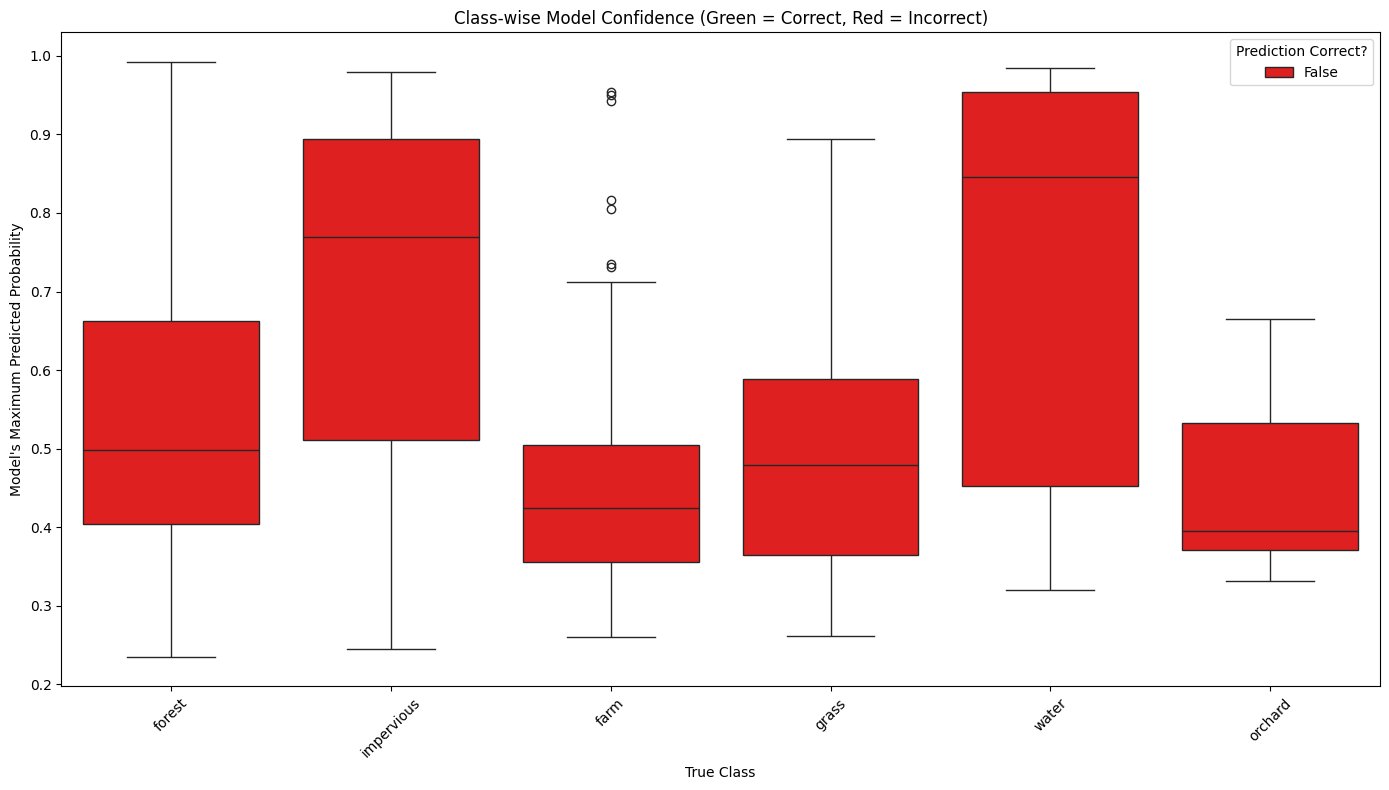

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Get probabilities and predictions
y_probs = best_model.predict_proba(X_val_scaled)
y_preds = best_model.predict(X_val_scaled)

# Create DataFrame without inverse_transform
confidence_df = pd.DataFrame({
    'true': y_val,
    'pred': y_preds,
    'max_prob': y_probs.max(axis=1),
    'correct': (y_val == y_preds)
})

# Plot class-wise confidence
plt.figure(figsize=(14, 8))
sns.boxplot(data=confidence_df, x='true', y='max_prob', hue='correct', palette={True: 'green', False: 'red'})
plt.title("Class-wise Model Confidence (Green = Correct, Red = Incorrect)")
plt.xlabel("True Class")
plt.ylabel("Model's Maximum Predicted Probability")
plt.legend(title="Prediction Correct?")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# Load and preprocess
df = pd.read_csv('train.csv')
X = df.drop(columns='class')
y = df['class']

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

# Build pipeline with imputer + scaler + logistic regression
base_model = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),   # handle NaNs
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Calibrate with isotonic regression
calibrated_clf = CalibratedClassifierCV(base_model, method='isotonic', cv=5)
calibrated_clf.fit(X_train, y_train)

# Predict probabilities and apply thresholds
y_probs = calibrated_clf.predict_proba(X_val)
thresholds = {i: 0.5 for i in range(len(le.classes_))}  # Default threshold: 0.5

final_preds = []
for i in range(len(y_probs)):
    max_prob = np.max(y_probs[i])
    class_pred = np.argmax(y_probs[i])
    if max_prob >= thresholds[class_pred]:
        final_preds.append(class_pred)
    else:
        final_preds.append(np.bincount(y_train).argmax())  # fallback to majority class

# Report
print(classification_report(y_val, final_preds, target_names=le.classes_))


              precision    recall  f1-score   support

        farm       0.89      0.80      0.84       168
      forest       0.96      1.00      0.98      1232
       grass       0.78      0.36      0.49        39
  impervious       0.84      0.87      0.85       134
     orchard       0.50      0.33      0.40         6
       water       0.00      0.00      0.00        21

    accuracy                           0.94      1600
   macro avg       0.66      0.56      0.59      1600
weighted avg       0.92      0.94      0.93      1600



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Load and preprocess test set
test_df = pd.read_csv("test.csv")

# Use the imputer and scaler from pipeline
X_test = test_df.copy()
test_probs = calibrated_clf.predict_proba(X_test)

# Apply thresholds
test_final_preds = []
for i in range(len(test_probs)):
    max_prob = np.max(test_probs[i])
    class_pred = np.argmax(test_probs[i])
    if max_prob >= thresholds[class_pred]:
        test_final_preds.append(class_pred)
    else:
        test_final_preds.append(np.bincount(y_train).argmax())

# Decode to original labels
submission_labels = le.inverse_transform(test_final_preds)

# Save submission
submission = pd.DataFrame({'ID': test_df.index, 'label': submission_labels})
submission.to_csv("submission13.csv", index=False)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

from scipy.signal import savgol_filter, find_peaks
from scipy.fft import fft

RANDOM_STATE = 42
PCA_COMPONENTS = 3
THRESHOLDS = {}  # Will be populated later

NDVI_COLS = [
    '20150720_N','20150602_N','20150517_N','20150501_N','20150415_N','20150330_N',
    '20150314_N','20150226_N','20150210_N','20150125_N','20150109_N','20141117_N',
    '20141101_N','20141016_N','20140930_N','20140813_N','20140626_N','20140610_N',
    '20140525_N','20140509_N','20140423_N','20140407_N','20140322_N','20140218_N',
    '20140202_N','20140117_N','20140101_N'
]


In [ ]:
def process_time_series(ts):
    ts = pd.Series(ts).interpolate(method='linear', limit_direction='both')
    if ts.isna().any():
        ts.fillna(ts.median(), inplace=True)
    if len(ts) > 7:
        try:
            w = min(7, len(ts) // 2)
            if w % 2 == 0: w -= 1
            ts = savgol_filter(ts, window_length=w, polyorder=2)
        except:
            pass
    return ts

def extract_features(ts):
    features = [
        np.mean(ts), np.median(ts), np.std(ts), np.ptp(ts),
        np.percentile(ts, 25), np.percentile(ts, 75),
        np.percentile(ts, 75) - np.percentile(ts, 25)
    ]
    try:
        peaks, _ = find_peaks(ts, distance=3)
        features += [
            len(peaks),
            np.mean(np.diff(peaks)) if len(peaks) > 1 else 0,
            np.mean(ts[peaks]) if len(peaks) > 0 else 0
        ]
    except:
        features += [0, 0, 0]
    try:
        fft_vals = np.abs(fft(ts))
        features += [
            np.argmax(fft_vals[1:len(fft_vals)//2]) + 1,
            np.max(fft_vals),
            np.sum(fft_vals[:5])
        ]
    except:
        features += [0, 0, 0]
    return features


In [ ]:
def train_pipeline(train_df):
    X_features, X_series = [], []
    for _, row in train_df.iterrows():
        ts = process_time_series(row[NDVI_COLS].values.astype(float))
        X_series.append(ts)
        X_features.append(extract_features(ts))

    pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X_series)

    X = np.hstack([X_features, X_pca])
    y = train_df['class']
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    selector = SelectKBest(f_classif, k=15)
    X_selected = selector.fit_transform(X, y_encoded)

    X_train, X_val, y_train, y_val = train_test_split(
        X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=RANDOM_STATE
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    base_model = LogisticRegression(max_iter=2000, class_weight='balanced', solver='saga')
    calibrated = CalibratedClassifierCV(base_model, method='isotonic', cv=3)
    calibrated.fit(X_train_scaled, y_train)

    y_probs = calibrated.predict_proba(X_val_scaled)
    y_preds = np.argmax(y_probs, axis=1)

    print("\n📊 Validation Report:\n")
    print(classification_report(y_val, y_preds, target_names=le.classes_))

    # Compute class-wise thresholds
    thresholds = {}
    for i, class_name in enumerate(le.classes_):
        prec, rec, thresh = precision_recall_curve((y_val == i).astype(int), y_probs[:, i])
        f1 = 2 * (prec * rec) / (prec + rec + 1e-6)
        best_thresh = thresh[np.argmax(f1)]
        thresholds[class_name] = best_thresh

    return calibrated, scaler, selector, pca, le, thresholds


In [ ]:
def test_inference(test_df, model, scaler, selector, pca, le, thresholds):
    X_features, X_series = [], []
    for _, row in test_df.iterrows():
        ts = process_time_series(row[NDVI_COLS].values.astype(float))
        X_series.append(ts)
        X_features.append(extract_features(ts))

    X_pca = pca.transform(X_series)
    X = np.hstack([X_features, X_pca])
    X_selected = selector.transform(X)
    X_scaled = scaler.transform(X_selected)
    probs = model.predict_proba(X_scaled)

    preds = []
    for row in probs:
        best_class = None
        for i, prob in enumerate(row):
            if prob >= thresholds[le.classes_[i]]:
                best_class = i
                break
        if best_class is None:
            best_class = np.argmax(row)
        preds.append(best_class)

    return le.inverse_transform(preds)


In [ ]:
# Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Train
model, scaler, selector, pca, le, thresholds = train_pipeline(train_df)

# Inference
predictions = test_inference(test_df, model, scaler, selector, pca, le, thresholds)

# Submission
submission = pd.DataFrame({
    "ID": test_df["ID"],
    "class": predictions
})
submission.to_csv("submission12.csv", index=False)
print("✅ Submission saved successfully as submission.csv")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labe


📊 Validation Report:

              precision    recall  f1-score   support

        farm       0.00      0.00      0.00       168
      forest       0.83      0.99      0.91      1232
       grass       0.00      0.00      0.00        39
  impervious       0.78      0.69      0.73       134
     orchard       0.00      0.00      0.00         6
       water       0.86      0.57      0.69        21

    accuracy                           0.83      1600
   macro avg       0.41      0.38      0.39      1600
weighted avg       0.72      0.83      0.77      1600

✅ Submission saved successfully as submission.csv


In [ ]:
# ✅ Segment 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import xgboost as xgb
from collections import Counter


In [ ]:
# ✅ Segment 2: Load and Preprocess Training Data
df = pd.read_csv("train.csv")

# Drop rows with missing label
df = df.dropna(subset=["class"])
y = df["class"]

# NDVI columns
ndvi_cols = [col for col in df.columns if col.endswith("_N")]
X = df[ndvi_cols]

# Impute missing values
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
X_df = pd.DataFrame(X_imputed, columns=ndvi_cols)


In [ ]:
# ✅ Segment 3: Drop Highly Correlated Columns
corr_matrix = X_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
print(f"❌ Dropping correlated columns: {to_drop}")
X_reduced = X_df.drop(columns=to_drop)


❌ Dropping correlated columns: []


In [ ]:
# ✅ Segment 4: Add NDVI Mean and Std as Features
X_reduced["ndvi_mean"] = X_reduced.mean(axis=1)
X_reduced["ndvi_std"] = X_reduced.std(axis=1)


In [ ]:
# ✅ Segment 5: Encode Labels if Necessary
# Assuming labels are already strings like 'forest', 'water', etc.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Save encoder for test set

# Optional: check class mapping
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Class mapping: {'farm': np.int64(0), 'forest': np.int64(1), 'grass': np.int64(2), 'impervious': np.int64(3), 'orchard': np.int64(4), 'water': np.int64(5)}


In [ ]:
# ✅ Segment 6: Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(
    X_reduced, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


In [ ]:
# ✅ Segment 7: Compute Class Weights
class_counts = Counter(y_train)
total = sum(class_counts.values())
num_classes = len(class_counts)
class_weights = {cls: total / (num_classes * count) for cls, count in class_counts.items()}

# Assign weights to training examples
weights = np.array([class_weights[y] for y in y_train])


In [ ]:
# ✅ Segment 8: Train XGBoost Classifier
model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes,
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train, sample_weight=weights)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:41:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=6, num_parallel_tree=None, ...)

In [ ]:
# ✅ Segment 9: Evaluation
y_val_pred = model.predict(X_val)
print("\n📊 Validation Classification Report:\n")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))



📊 Validation Classification Report:

              precision    recall  f1-score   support

        farm       0.86      0.88      0.87       168
      forest       0.98      0.99      0.99      1232
       grass       0.93      0.72      0.81        39
  impervious       0.86      0.90      0.88       134
     orchard       1.00      0.17      0.29         6
       water       0.84      0.76      0.80        21

    accuracy                           0.96      1600
   macro avg       0.91      0.74      0.77      1600
weighted avg       0.96      0.96      0.95      1600



In [ ]:
# ✅ Segment 10: Test Set Inference and Submission (fixed ID issue)
test_df = pd.read_csv("test.csv")
test_ids = test_df["id"] if "id" in test_df.columns else np.arange(1, len(test_df) + 1)

X_test = test_df[ndvi_cols]
X_test_imputed = imputer.transform(X_test)
X_test_df = pd.DataFrame(X_test_imputed, columns=ndvi_cols)

X_test_reduced = X_test_df.drop(columns=to_drop)
X_test_reduced["ndvi_mean"] = X_test_reduced.mean(axis=1)
X_test_reduced["ndvi_std"] = X_test_reduced.std(axis=1)

y_test_pred_encoded = model.predict(X_test_reduced)
y_test_pred = le.inverse_transform(y_test_pred_encoded)

submission = pd.DataFrame({
    "ID": test_ids,
    "class": y_test_pred
})

submission.to_csv("submission2.csv", index=False)
print("✅ Submission file saved as 'submission.csv' with correct ID format")


✅ Submission file saved as 'submission.csv' with correct ID format


In [ ]:
kaggle competitions submit -c summer-analytics-mid-hackathon -f submission.csv -m "Message"

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from collections import Counter

# Load training data
df = pd.read_csv("train.csv")

# Drop 'id' column if present
if 'ID' in df.columns:
    df.drop(columns=["ID"], inplace=True)

# Drop rows with missing labels
df = df.dropna(subset=["class"])

# Feature columns
ndvi_cols = [col for col in df.columns if col.endswith("_N")]
X = df[ndvi_cols]
y = df["class"]

# Label encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Drop highly correlated features
X_df = pd.DataFrame(X_imputed, columns=ndvi_cols)
corr_matrix = X_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
X_dropped = X_df.drop(columns=to_drop)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dropped)

# PCA
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(
    X_pca, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Compute class weights
class_counts = Counter(y_train)
total = sum(class_counts.values())
num_classes = len(class_counts)
weights = {k: total / (num_classes * v) for k, v in class_counts.items()}
sample_weights = np.array([weights[label] for label in y_train])

# Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train, sample_weight=sample_weights)

# Validation performance
y_val_pred = model.predict(X_val)
print("\n📊 Validation Classification Report:\n")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

# --- Test prediction ---
test_df = pd.read_csv("test.csv")
test_ids = test_df["id"] if "id" in test_df.columns else pd.Series(np.arange(1, len(test_df) + 1))

# Preprocess test data
X_test = test_df[ndvi_cols]
X_test_imputed = imputer.transform(X_test)
X_test_df = pd.DataFrame(X_test_imputed, columns=ndvi_cols)
X_test_dropped = X_test_df.drop(columns=to_drop)
X_test_scaled = scaler.transform(X_test_dropped)
X_test_pca = pca.transform(X_test_scaled)

# Predict test labels
y_test_pred_encoded = model.predict(X_test_pca)
y_test_pred = label_encoder.inverse_transform(y_test_pred_encoded)

# Submission
submission = pd.DataFrame({
    "ID": test_ids.astype(int),
    "class": y_test_pred
})
submission.to_csv("submission12.csv", index=False)
print("✅ submission.csv saved")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:52:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Validation Classification Report:

              precision    recall  f1-score   support

        farm       0.80      0.78      0.79       168
      forest       0.97      0.98      0.97      1232
       grass       0.80      0.62      0.70        39
  impervious       0.79      0.86      0.82       134
     orchard       1.00      0.50      0.67         6
       water       0.83      0.48      0.61        21

    accuracy                           0.93      1600
   macro avg       0.87      0.70      0.76      1600
weighted avg       0.93      0.93      0.93      1600

✅ submission.csv saved


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_sample_weight

# Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Drop 'id' column if it exists
if 'ID' in train_df.columns:
    train_df = train_df.drop(columns=['ID'])
if 'ID' in test_df.columns:
    test_ids = test_df['ID']
    test_df = test_df.drop(columns=['ID'])
else:
    test_ids = pd.Series(range(1, len(test_df) + 1))

# Separate features and target
X = train_df.drop(columns=['class'])
y = train_df['class']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Impute and scale
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(test_df)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train, sample_weight=sample_weights)

# Evaluate
y_val_pred = model.predict(X_val)
print("Validation Classification Report:\n")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

# Predict on test data
y_test_pred = model.predict(X_test_scaled)
test_preds_labels = le.inverse_transform(y_test_pred)

# Match class distribution
desired_distribution = {
    'farm': 650,
    'forest': 1450,
    'grass': 300,
    'impervious': 450,
    'orchard': 50,
    'water': 200
}
desired_total = sum(desired_distribution.values())

# Downsample predictions to match the desired distribution
test_df_with_preds = pd.DataFrame({'ID': test_ids, 'class': test_preds_labels})
final_predictions = pd.DataFrame()

for label, count in desired_distribution.items():
    label_df = test_df_with_preds[test_df_with_preds['class'] == label]
    if len(label_df) > count:
        label_df = label_df.sample(n=count, random_state=42)
    final_predictions = pd.concat([final_predictions, label_df])

# If we sampled fewer than desired total, randomly sample the rest
if len(final_predictions) < desired_total:
    remaining = desired_total - len(final_predictions)
    leftover = test_df_with_preds[~test_df_with_preds.index.isin(final_predictions.index)]
    if len(leftover) < remaining:
      supplement = leftover.sample(n=remaining, random_state=42, replace=True)
    else:
      supplement = leftover.sample(n=remaining, random_state=42)

    final_predictions = pd.concat([final_predictions, supplement])

# Final formatting
final_predictions = final_predictions.sort_values(by='ID')
final_predictions.to_csv("final_submission.csv", index=False)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Classification Report:

              precision    recall  f1-score   support

        farm       0.94      0.96      0.95       168
      forest       1.00      1.00      1.00      1232
       grass       1.00      0.79      0.89        39
  impervious       0.91      0.95      0.93       134
     orchard       0.80      0.67      0.73         6
       water       0.91      0.95      0.93        21

    accuracy                           0.98      1600
   macro avg       0.93      0.89      0.90      1600
weighted avg       0.98      0.98      0.98      1600




Missing value counts per column:
 Unnamed: 0       0
20150720_N     560
20150602_N    1200
20150517_N     800
20150501_N     960
20150415_N     480
20150330_N    1120
20150314_N     720
20150226_N    1360
20150210_N     640
20150125_N    1040
20150109_N     880
20141117_N    1280
20141101_N     400
20141016_N    1440
20140930_N     800
20140813_N     560
20140626_N    1600
20140610_N     480
20140525_N     720
20140509_N     880
20140423_N    1760
20140407_N     640
20140322_N    1120
20140218_N    1440
20140202_N     560
20140117_N    1200
20140101_N     400
dtype: int64


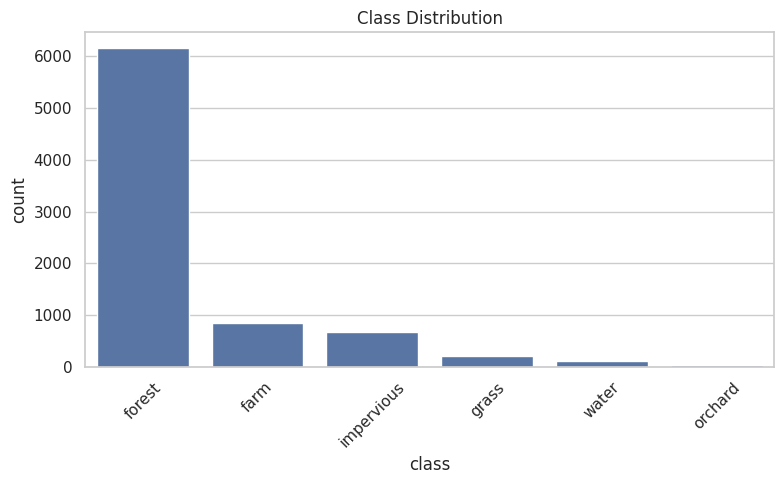

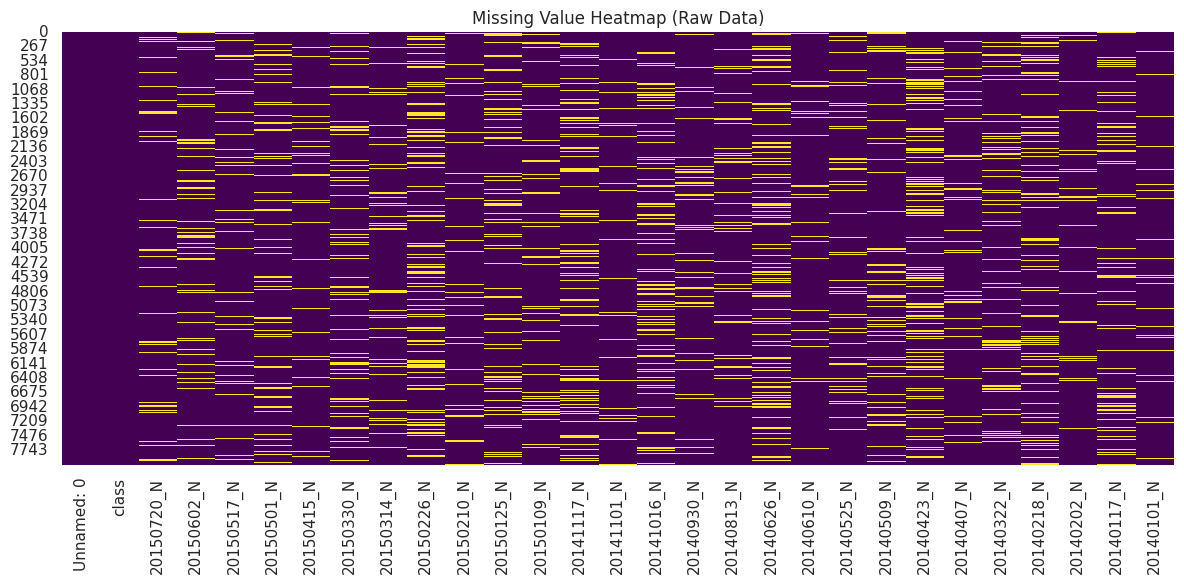

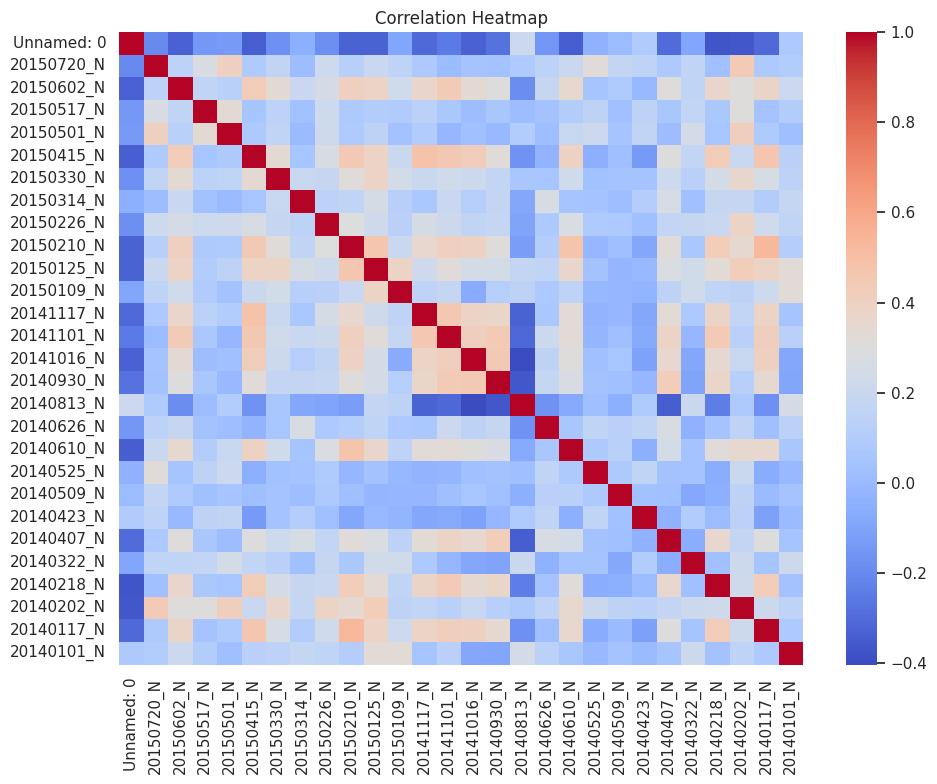

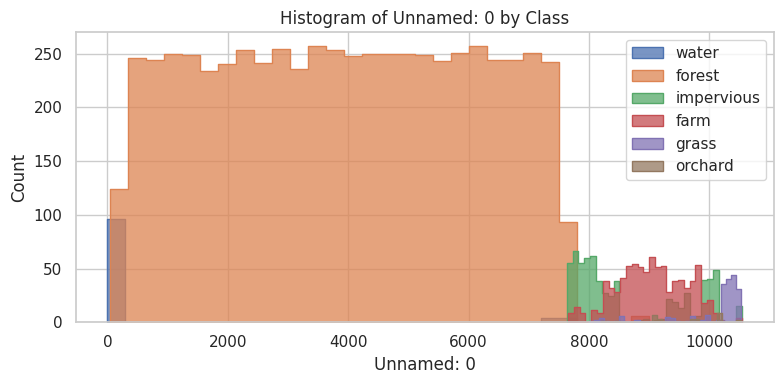

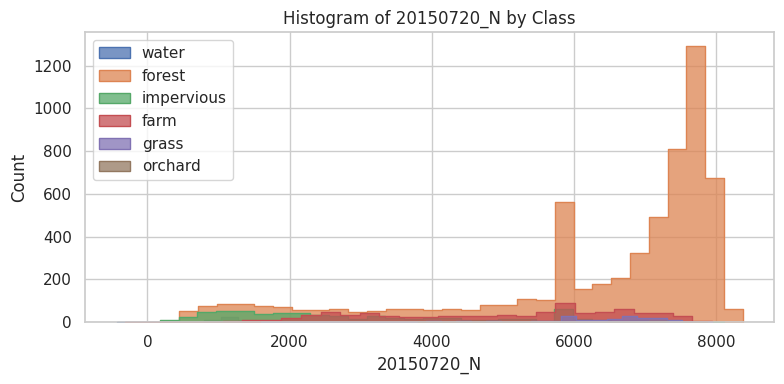

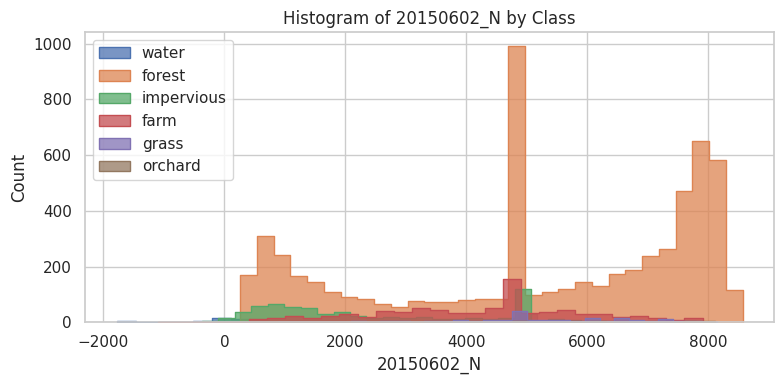

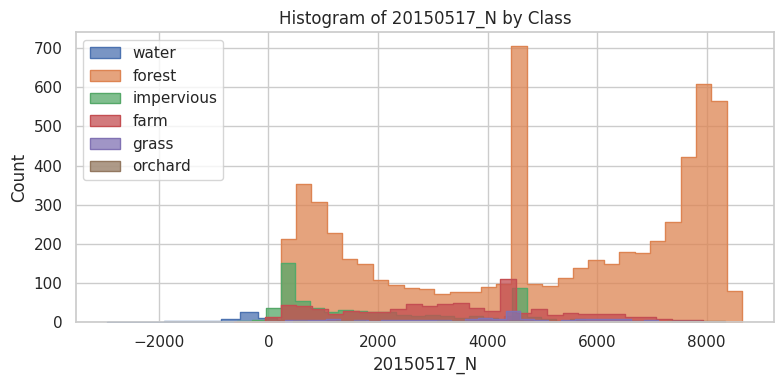

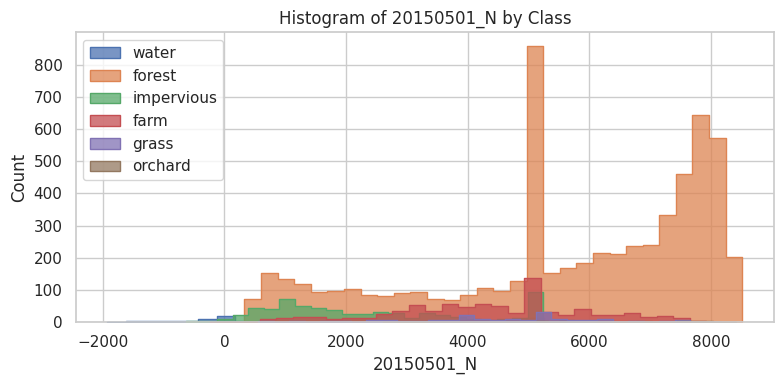

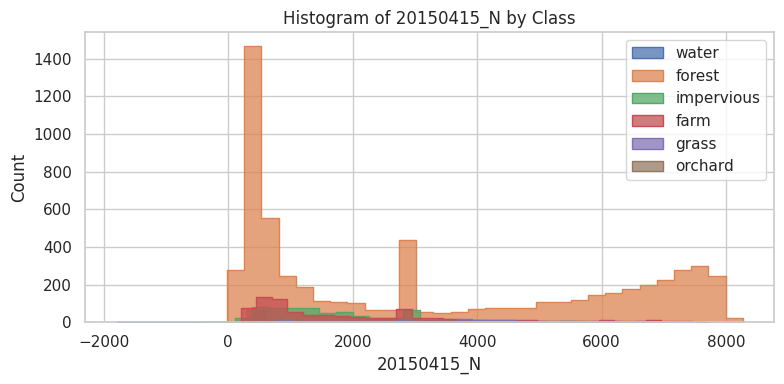

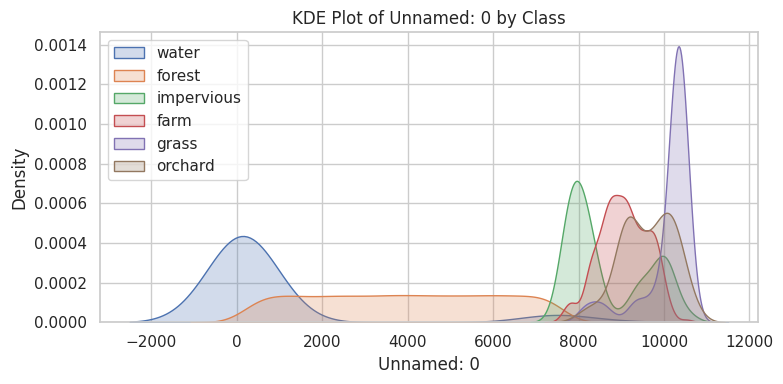

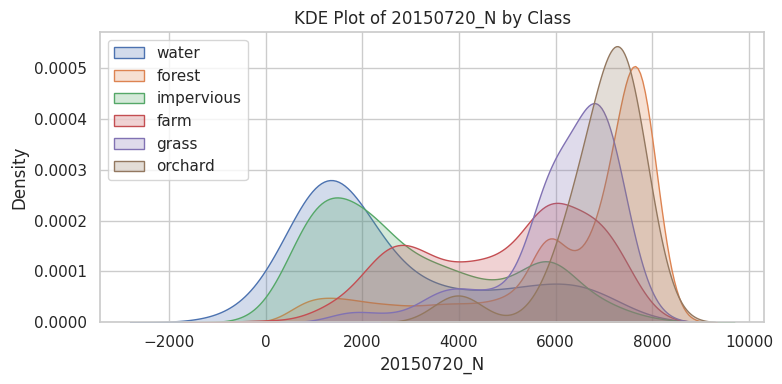

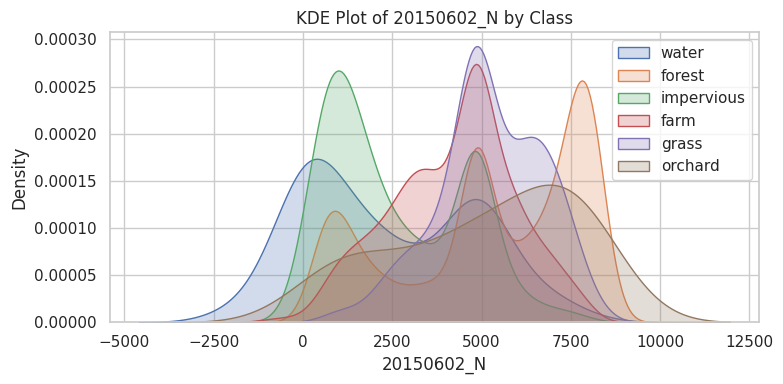

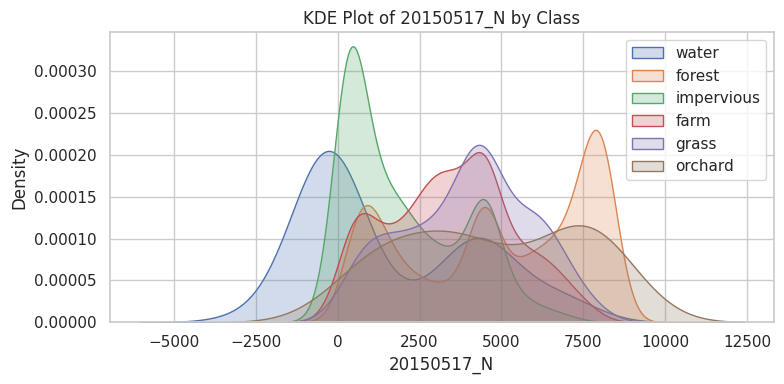

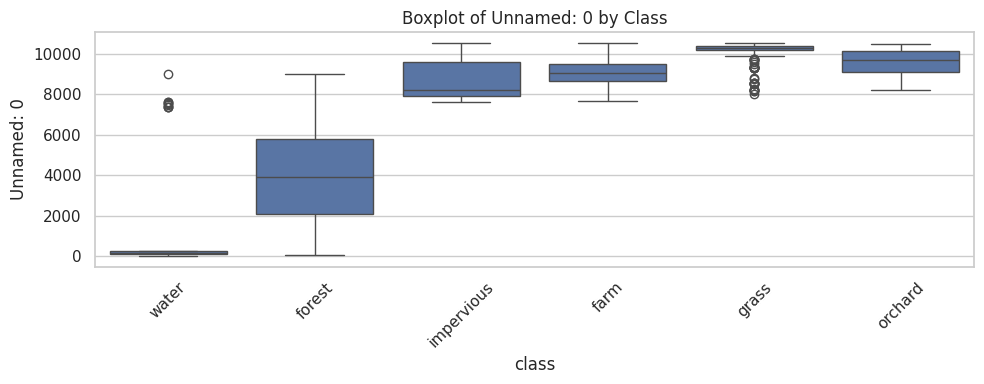

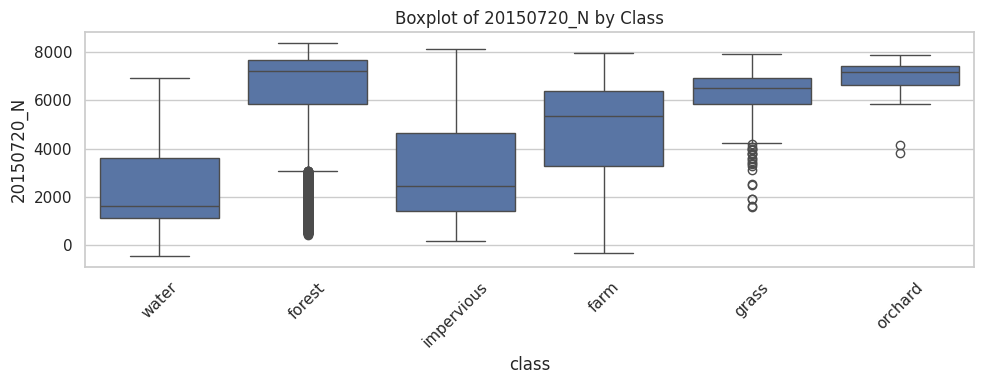

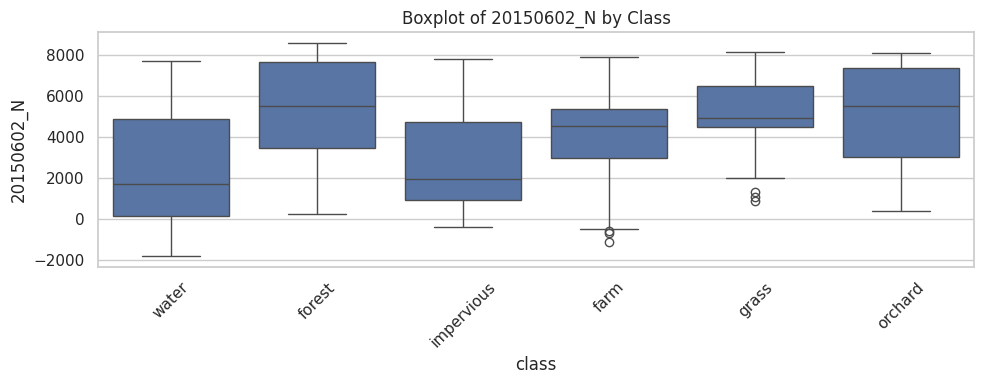

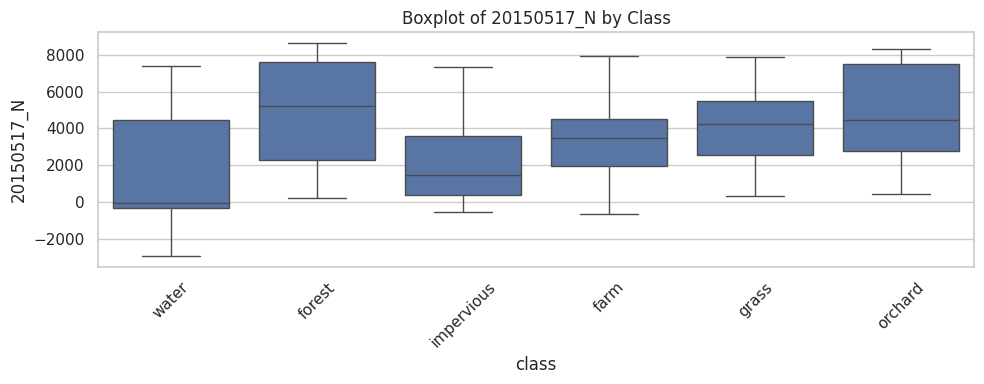

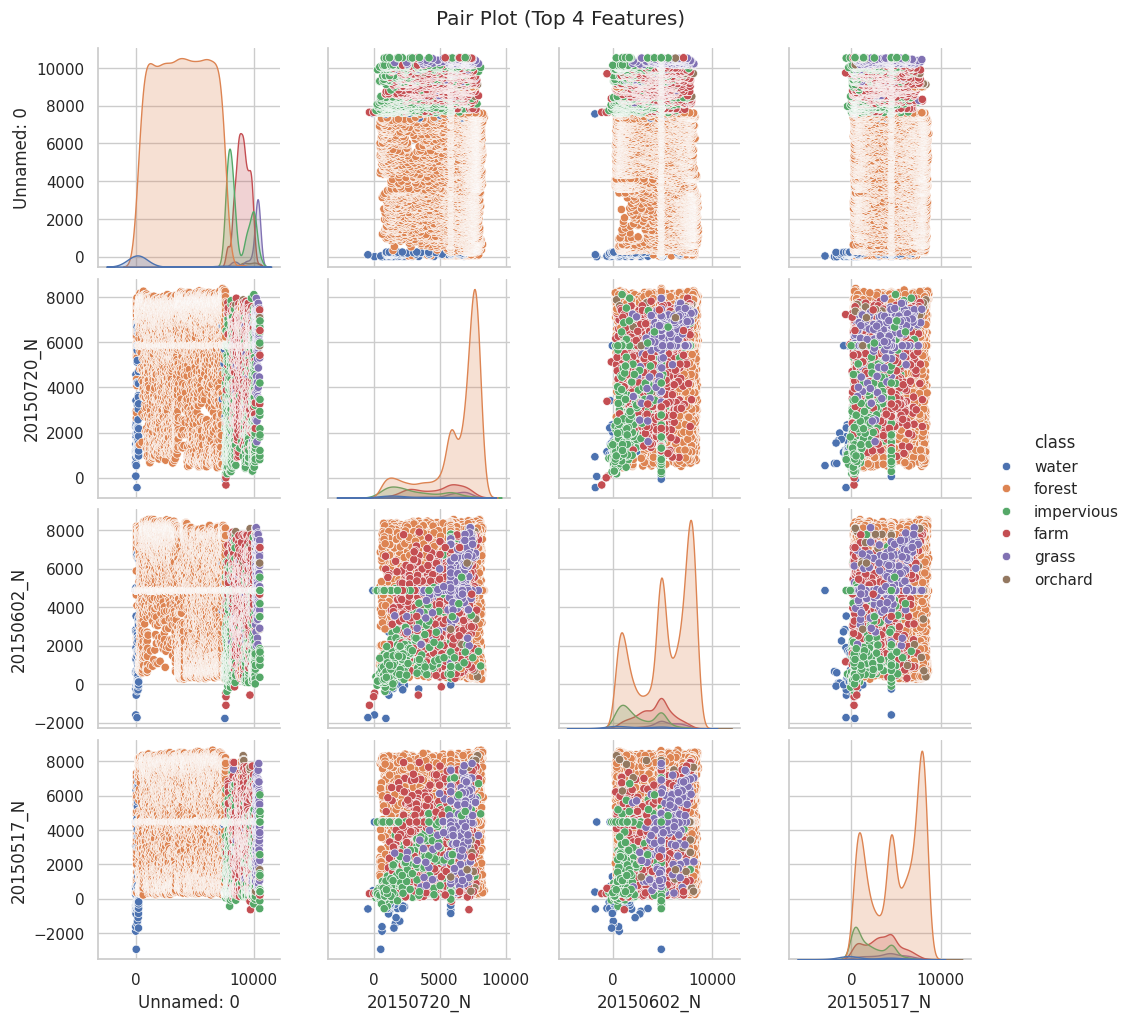

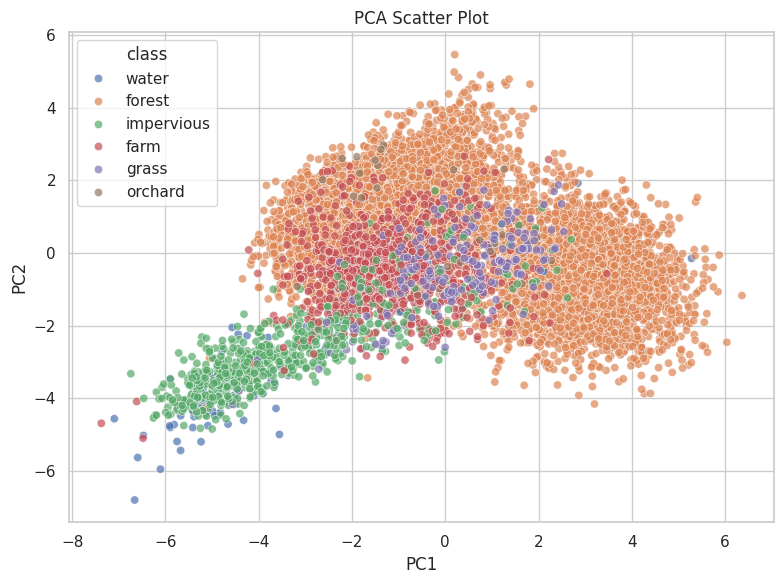

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


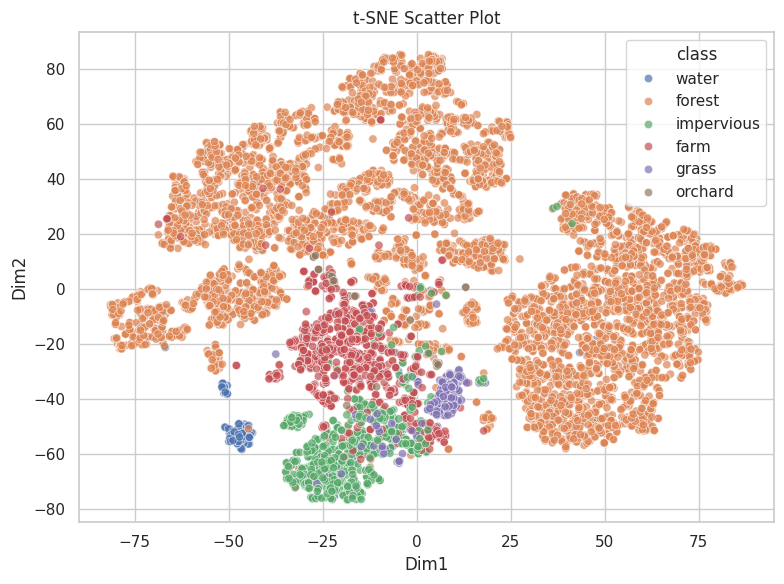

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid")

# === Load Data ===
df = pd.read_csv("train.csv")
df.drop(columns=['ID'], inplace=True, errors='ignore')

# === Split features and target ===
target_col = 'class'
X = df.drop(columns=[target_col])
y = df[target_col]

# === Print NaN Summary ===
print("\nMissing value counts per column:\n", X.isna().sum())

# === Handle Missing Values ===
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

# === Standardize the Data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed_df)

# === Class Distribution ===
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x=target_col, order=df[target_col].value_counts().index)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Missing Value Heatmap (before imputation) ===
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Value Heatmap (Raw Data)")
plt.tight_layout()
plt.show()

# === Correlation Heatmap ===
plt.figure(figsize=(10, 8))
sns.heatmap(X_imputed_df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# === Histograms by Class (Top 6 Features) ===
for col in X_imputed_df.columns[:6]:
    plt.figure(figsize=(8, 4))
    for label in df[target_col].unique():
        sns.histplot(X_imputed_df[y == label][col], label=label, bins=30, element='step')
    plt.title(f"Histogram of {col} by Class")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === KDE Plots (Top 4 Features) ===
for col in X_imputed_df.columns[:4]:
    plt.figure(figsize=(8, 4))
    for label in df[target_col].unique():
        sns.kdeplot(X_imputed_df[y == label][col], label=label, fill=True)
    plt.title(f"KDE Plot of {col} by Class")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Boxplots (Top 4 Features) ===
for col in X_imputed_df.columns[:4]:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=y, y=X_imputed_df[col])
    plt.title(f"Boxplot of {col} by Class")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === Pair Plot (Top 4 Features) ===
subset_df = X_imputed_df[X_imputed_df.columns[:4]].copy()
subset_df[target_col] = y.values
sns.pairplot(subset_df, hue=target_col)
plt.suptitle("Pair Plot (Top 4 Features)", y=1.02)
plt.show()

# === PCA Scatter Plot ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df[target_col] = y.values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=target_col, alpha=0.7)
plt.title("PCA Scatter Plot")
plt.tight_layout()
plt.show()

# === t-SNE Scatter Plot ===
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df[target_col] = y.values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue=target_col, alpha=0.7)
plt.title("t-SNE Scatter Plot")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

# Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Drop ID column
train_df.drop(columns=['ID'], inplace=True)
test_ids = test_df['ID']
test_df.drop(columns=['ID'], inplace=True)

# Separate features and target
X = train_df.drop(columns=['class'])
y = train_df['class']

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# KNN Imputation (handles NaNs better than mean)
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
test_imputed = imputer.transform(test_df)

# SMOTE to handle imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y_encoded)

# 5-fold stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros((X_resampled.shape[0], len(le.classes_)))
test_preds = np.zeros((test_df.shape[0], len(le.classes_)))

# LightGBM training with early stopping
for fold, (train_idx, val_idx) in enumerate(skf.split(X_resampled, y_resampled)):
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    model = LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        class_weight='balanced',
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
    )

    oof_preds[val_idx] = model.predict_proba(X_val)
    test_preds += model.predict_proba(test_imputed) / skf.n_splits

# Get final predictions
oof_labels = np.argmax(oof_preds, axis=1)
test_labels = np.argmax(test_preds, axis=1)

# Calculate CV F1 Score
cv_score = f1_score(y_resampled, oof_labels, average='macro')

# Decode predictions
final_preds = le.inverse_transform(test_labels)

# Create submission
submission = pd.DataFrame({
    'id': test_ids,
    'label': final_preds
})

cv_score, submission.head()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 29563, number of used features: 28
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 29563, number of used features: 28
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 29563, number of used features: 28
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 29563, number of used features: 28
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 29564, number of used features: 28
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791760
[LightGBM] [Info] Start training from score -1.791760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(0.9986741170905753,
    id   label
 0   1  forest
 1   2  forest
 2   3  forest
 3   4  forest
 4   5  forest)